In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
import pyabf

from utils import *
from deconv import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [48]:
data_path = "/mnt/Data/hanson_sac_velocity/June4_21_C1/"
base_abf_name = "210604_0"
ex_abf = pyabf.ABF(os.path.join(data_path, base_abf_name + "107.abf"))
print(ex_abf)

ABF (v2.6) with 2 channels (pA, pA), sampled at 10.0 kHz, containing 3 sweeps, having no tags, with a total length of 0.47 minutes, recorded with protocol "noPulse".


In [50]:
stim_info = pd.read_excel(os.path.join(data_path, "stim_info.xlsx"), index_col=0, skiprows=1)
stim_info

,Velocity,Holding
File #,,
107,5000,-60
108,4000,-60
109,3000,-60
110,2000,-60
111,1000,-60
112,500,-60
113,300,-60
114,100,-60
115,100,0


In [41]:
epsc_vels = stim_info.query("Holding == -60").filter(["Velocity"], axis="columns")
epsc_vels = epsc_vels.query("index >= 107 and index <= 114").sort_values(by="Velocity") 

ipsc_vels = stim_info.query("Holding == 0").filter(["Velocity"], axis="columns")
ipsc_vels = ipsc_vels.query("index >= 115 and index <= 122").sort_values(by="Velocity")

In [47]:
epsc_vels

,Velocity
File #,
114,100
113,300
112,500
111,1000
110,2000
109,3000
108,4000
107,5000


In [46]:
ipsc_vels

,Velocity
File #,
115,100
116,300
117,500
118,1000
119,2000
120,3000
121,4000
122,5000


<IPython.core.display.Javascript object>


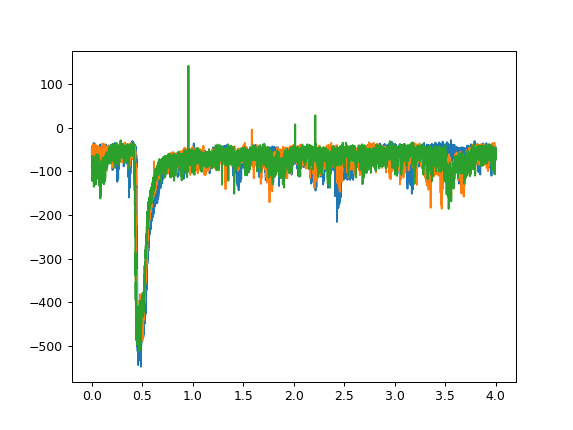

In [4]:
ex_fig, ex_ax = plt.subplots(1)
for i in range(3):
    ex_abf.setSweep(i)
    plt.plot(ex_abf.sweepX, ex_abf.sweepY)

In [100]:
def load_vel_recs(table):
    xaxes = {}
    recs = {}
    for num, row in table.iterrows():
        vel = row["Velocity"]
        abf = pyabf.ABF(os.path.join(data_path, "%s%i.abf" % (base_abf_name, num)))
        
        ys = []
        for i in abf.sweepList:
            abf.setSweep(i)
            ys.append(np.array(abf.sweepY))
            
        xaxes[vel] = np.array(abf.sweepX)
        recs[vel] = np.stack(ys, axis=0)
        
    return xaxes, recs

epsc_xaxes, epsc_recs = load_vel_recs(epsc_vels) 
ipsc_xaxes, ipsc_recs = load_vel_recs(ipsc_vels) 
dt = epsc_xaxes[1000][1] - epsc_xaxes[1000][0]

In [89]:
# vel_fig, vel_ax = plt.subplots(len(epsc_xaxes), sharex=True, figsize=(8, 12))
# for ax, vel in zip(vel_ax, epsc_xaxes.keys()):
#     ax.plot(epsc_xaxes[vel], epsc_recs[vel].mean(axis=0)) 
#     ax.plot(ipsc_xaxes[vel], ipsc_recs[vel].mean(axis=0)) 
#     ax.set_ylabel("%i μm/s" % vel)
    
# vel_ax[-1].set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


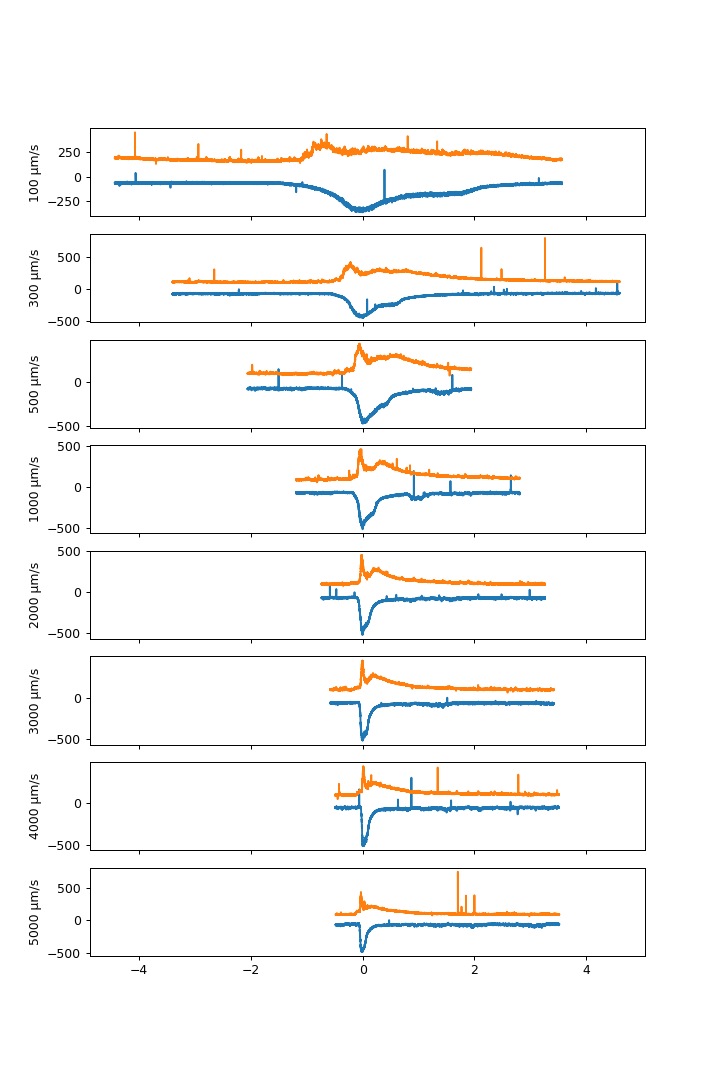

Text(0.5, 91.52736318407958, 'Time (s)')

In [90]:
aligned_vel_fig, aligned_vel_ax = plt.subplots(len(epsc_xaxes), sharex=True, figsize=(8, 12))
for ax, vel in zip(aligned_vel_ax, epsc_xaxes.keys()):
    ec = epsc_recs[vel].mean(axis=0)
    ic = ipsc_recs[vel].mean(axis=0)
    t = epsc_xaxes[vel][ec.argmin()]
    
    ax.plot(epsc_xaxes[vel] - t, ec) 
    ax.plot(ipsc_xaxes[vel] - t, ic) 
    ax.set_ylabel("%i μm/s" % vel)
    
vel_ax[-1].set_xlabel("Time (s)")

In [ ]:
tau1 = 2 # rise [ms]
tau2 = 30  # decay [ms]
quantum_pts = 100
fitter = BiexpFitter(1, 10, norm_amp=True)

i500_alpha = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

<IPython.core.display.Javascript object>


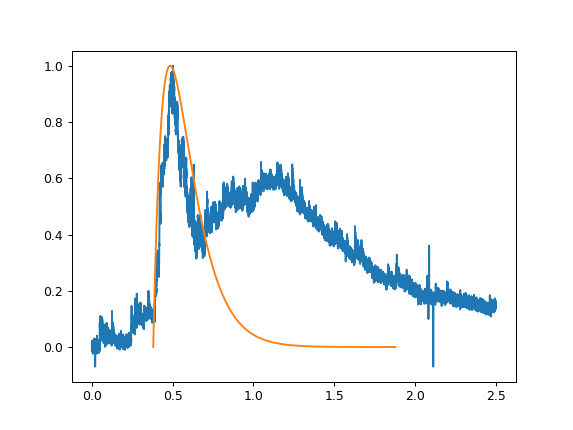

In [124]:
start = nearest_index(ipsc_xaxes[500], 1.5)
crop_ipsc_500 = np.mean(ipsc_recs[500], axis=0)[start:]
crop_ipsc_500 -= np.mean(crop_ipsc_500[:100])
crop_ipsc_500 /= np.max(crop_ipsc_500)
crop_ipsc_500_ax = np.arange(len(crop_ipsc_500)) * (ipsc_xaxes[500][1] - ipsc_xaxes[500][0])

i500_alpha = BiexpFitter(1, 10, norm_amp=True).model(
    t=np.arange(15000), 
    tau1=.1 / dt, # convert to match resulting sample-rate to data
    tau2=0.11 / dt, 
    y0=1.,
)[0]
i500_alpha_xaxis = np.arange(len(i500_alpha)) * dt

i500_fig, i500_ax = plt.subplots(1)
i500_ax.plot(crop_ipsc_500_ax, crop_ipsc_500)
i500_ax.plot(i500_alpha_xaxis + 0.38, i500_alpha)

<IPython.core.display.Javascript object>


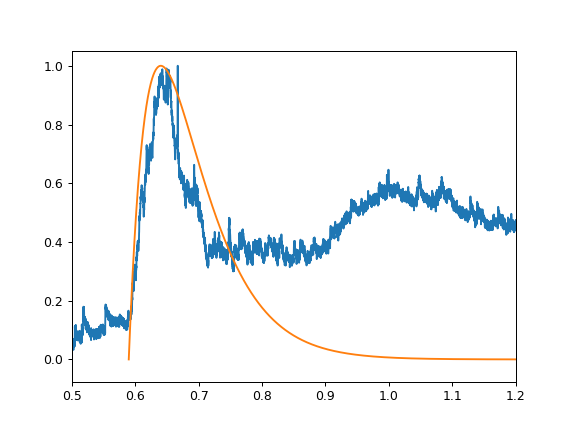

(0.5, 1.2)

In [141]:
start = nearest_index(ipsc_xaxes[1000], 0.5)
crop_ipsc_1000 = np.mean(ipsc_recs[1000], axis=0)[start:]
crop_ipsc_1000 -= np.mean(crop_ipsc_1000[:100])
crop_ipsc_1000 /= np.max(crop_ipsc_1000)
crop_ipsc_1000_ax = np.arange(len(crop_ipsc_1000)) * (ipsc_xaxes[1000][1] - ipsc_xaxes[1000][0])

i1000_alpha = BiexpFitter(1, 10, norm_amp=True).model(
    t=np.arange(15000), 
    tau1=.05 / dt, # convert to match resulting sample-rate to data
    tau2=0.051 / dt, 
    y0=1.,
)[0]
i1000_alpha_xaxis = np.arange(len(i1000_alpha)) * dt

i1000_fig, i1000_ax = plt.subplots(1)
i1000_ax.plot(crop_ipsc_1000_ax, crop_ipsc_1000)
i1000_ax.plot(i1000_alpha_xaxis + 0.59, i1000_alpha)
i1000_ax.set_xlim(0.5, 1.2)